In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
# ML
import torch
import torch.nn as nn
from sklearn import datasets

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.patches import Circle, Wedge, Polygon

# Math
import math
from math import cos, sin
import numpy as np
import random

## 1 Neural Network

In [3]:
def train(x, y, model, crit):
    idx = 0
    epochs = 1000
    print_iter = 100
    nrows = int(epochs / print_iter)
    
    o = []
    
    def hook(module, input, output):
        o.append(output)
        
    model[1].register_forward_hook(hook)

    
    # Create a subplot
    fig, ax = plt.subplots(nrows=nrows, ncols=4, figsize=(14, 18))

    for epoch in range(epochs):
        y_pred = model(x)
        loss = crit(y_pred,y)
        optimizer.zero_grad()
        loss.backward()  # back pass
        optimizer.step() # update params

        if (epoch % print_iter) == 0:
            """
            ax[idx][0].figure(1, figsize=(5,5))
            ax[idx][1].figure(1, figsize=(5,5))
            ax[idx][2].figure(1, figsize=(5,5))
            ax[idx][3].figure(1, figsize=(5,5))
            """
            
            plot_regions(x,y,model, ax[idx][0], "Epoch " + str(epoch))        
            # Print out model weights
            model_weights_plot(model, ax[idx][1], "Model Weights")
            # Print out the linear output values
            output_plot(model, o, ax[idx][2], "Linear Output Values")
            combined_plot(model, o, ax[idx][3], "|Ouput Value * Model Weight|")
            
            
            idx = idx + 1
        o = []

    
    plt.show()
        
    
    return loss

In [4]:
def model_weights_plot(model, s_plt, title):
    weights1 = np.array(model[0].weight.tolist())
    weights2 = np.array(model[2].weight.tolist())[0]
    s_plt.title.set_text(title)
    s_plt.bar(list(range(len(weights2))), weights2)
    s_plt.plot()
    
def output_plot(model, o, s_plt, title):
    a = np.array(o[0].tolist())
    t = np.sum(a, axis=0) / a.shape[0]
    s_plt.title.set_text(title)
    s_plt.bar(list(range(len(t))), t)
    
def combined_plot(model, o, s_plt, title):
    a = np.array(o[0].tolist())
    t = np.sum(a, axis=0) / a.shape[0]
    weights2 = np.array(model[2].weight.tolist())[0]
    c_plot = np.abs(weights2*t)
    #plt.title("|Ouput Value * Model Weight|")
    s_plt.title.set_text(title)
    s_plt.bar(list(range(len(c_plot))), c_plot)

    s_plt.plot()

In [5]:
def pred(model, x):
    o = []
        
    def hook(module, input, output):
        o.append(output)
        
    model[1].register_forward_hook(hook)
    
    
    
    #return values and outputs after first hidden layer
    return model(torch.FloatTensor(x)).tolist(), o

def rand_points():
    x_points = np.linspace(-5,10,300)
    y_points = np.linspace(-5,10,300)
    points = [[x,y] for x in x_points for y in y_points]
    return points

def train_vals(x):
    return ([z[0] for z in x.tolist()],[z[1] for z in x.tolist()])

def plot_regions(x,y,model, s_plt, title, idx=-1):
    x_train,y_train = train_vals(x)
    points = rand_points()
    x_map = [x[0] for x in points]
    y_map = [x[1] for x in points]
    val = pred(model,points)
    preds = val[0]
    out = val[1]    
    
    
    #get colors
    c1 = ['g','b']
    c2 = ['#E2E79F','#FF90FF']
    
    
    train_map = [c1[int(x[0])] for x in y.tolist()]
    cmap = [c2[0] if x[0] < 0.5 else c2[1] for x in preds]
    #plot points
    #print(len(x_map))
    s_plt.title.set_text(title)
    s_plt.scatter(x_map,y_map,color=cmap)
    s_plt.scatter(x_train,y_train,color=train_map,marker='o')
    
    #s_plt.xlabel('X1')
    #s_plt.ylabel('X2')
    #show classification regions
    if idx == -1:
        s_plt.plot()
    else:
        plt.subplot(5,2,idx)
        
    return out

In [6]:
# Notes

#how many different local optima are found?
#local optima are diff if different classification
# of training data
# decision boundry will be different every time, so it
# is not a  good measure

#also figure out how the weights are spread out
#visualize weights in relation to each other

#4 syntehtic data sets


#NN spread out weights

#look at SGD vs Adam

## 2 Synthetic data set generator

### 2.1 Generate circles and disks

In [7]:
def gen_circle(n, x, y, radius, disk_start=0, circ_start=0, circ_end=1, noise=False):
    """
    Generates points in within a specific disk.
    
    Args:
        - n: Number of points to generate
        - x: X-axis center of circle
        - y: Y-axis center of circle
        - radius:     Radius of circle
        - disk_start: [0, 1] where to start center of circle
        - circ_start: [0, 1] Start place of circle (Defaults 0 == 3PM).
        - circ_end:   [0, 1] End place of circle (Defaults 1 == 3PM, wraps around counter clockwise).
        - noise:      Add standard normal noise to data points
    """
    data = []
    for i in range(n):
        arc = random.uniform(circ_start, circ_end) * 2 * math.pi
        r = radius * np.sqrt(random.uniform(disk_start, 1))
        
        p_x = r * np.cos(arc) + x
        p_y = r * np.sin(arc) + y
        
        if noise:
            p_x += np.random.normal(0,1)
            p_y += np.random.normal(0,1)
            
        data.append([p_x, p_y])
    return data

### 2.2 Visualize two datasets

In [8]:
def plot(data1, data2):
    data1 = np.array(data1)
    data2 = np.array(data2)
    figure(num=None, figsize=(6, 6), dpi=120, facecolor='w', edgecolor='k')
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, aspect='equal')


    """
    axis = { 'xmin' : -10, 
             'xmax' : 10, 
             'ymin' : -10, 
             'ymax' : 10 }

    #ax2.add_artist(Circle((x, y), r, color=(1,0,0,.7)))
    plt.axis(**axis)"""
    plt.scatter(data1[:, 0], data1[:, 1])
    plt.scatter(data2[:, 0], data2[:, 1])
    plt.show()

## 3 Neural net visualization

### 3.1 Neural net hidden layer weight plot function

In [9]:

def show_weights(model):
    weights1 = np.array(model[0].weight.tolist())
    weights2 = np.array(model[2].weight.tolist())[0]
    plt.title("Model Weights")
    plt.bar(list(range(len(weights2))), weights2)
    plt.show()
    
def show_layer(outputs):
    print(np.shape(outputs))
    plt.bar(list(range(len(outputs))), outputs)
    plt.show()
    
def test_set():
    x_points = np.linspace(0,10,200)
    y_points = np.linspace(0,10,200)
    points = [[x,y] for x in x_points for y in y_points]
    return points



def do_all(x,y,H):
    for ind in range(1):
        print('---------------------------------------------------------------')
        model = nn.Sequential(nn.Linear(d,H),
                             nn.ReLU(),
                             nn.Linear(H,1),
                              nn.Sigmoid())

        crit = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
        loss = train(x,y,model,crit)
        print("The loss is " + str(loss.tolist()))

        o = []

        def hook(module, input, output):
            o.append(output)

        model[1].register_forward_hook(hook)

        plot_regions(x,y,model)
        show_weights(model)
        a = np.array(o[0].tolist())
        t = np.sum(a, axis=0) / a.shape[0]

        #plot_regions(x,y,model)
        #show_weights(model)
        show_layer(t)
        print('---------------------------------------------------------------')
        
        
def plot_fin_model(model, x, y):
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(14, 18))

    
    preds, output = pred(model, x)
    output = np.array(output[0].tolist())

    x = np.array(x.tolist())
    y = np.array(y.tolist())

    # Get average output for each class
    output0 = np.array([output[i] for i, y_i in enumerate(y) if y_i == 0])
    output1 = np.array([output[i] for i, y_i in enumerate(y) if y_i == 1])
    
    # Plot final output
    plot_regions(x, y, model, ax[0][0], "Output 0")        
    # Print out model weights
    model_weights_plot(model, ax[0][1], "Model Weights")
    # Print out the linear output values
    output_plot(model, [output0], ax[0][2], "Linear Output Values")
    combined_plot(model, [output0], ax[0][3], "|Ouput Value * Model Weight|")

    # Plot final output
    plot_regions(x, y, model, ax[1][0], "Output 1")        
    # Print out model weights
    model_weights_plot(model, ax[1][1], "Model Weights")
    # Print out the linear output values
    output_plot(model, [output1], ax[1][2], "Linear Output Values")
    combined_plot(model, [output1], ax[1][3], "|Ouput Value * Model Weight|")

## TMP

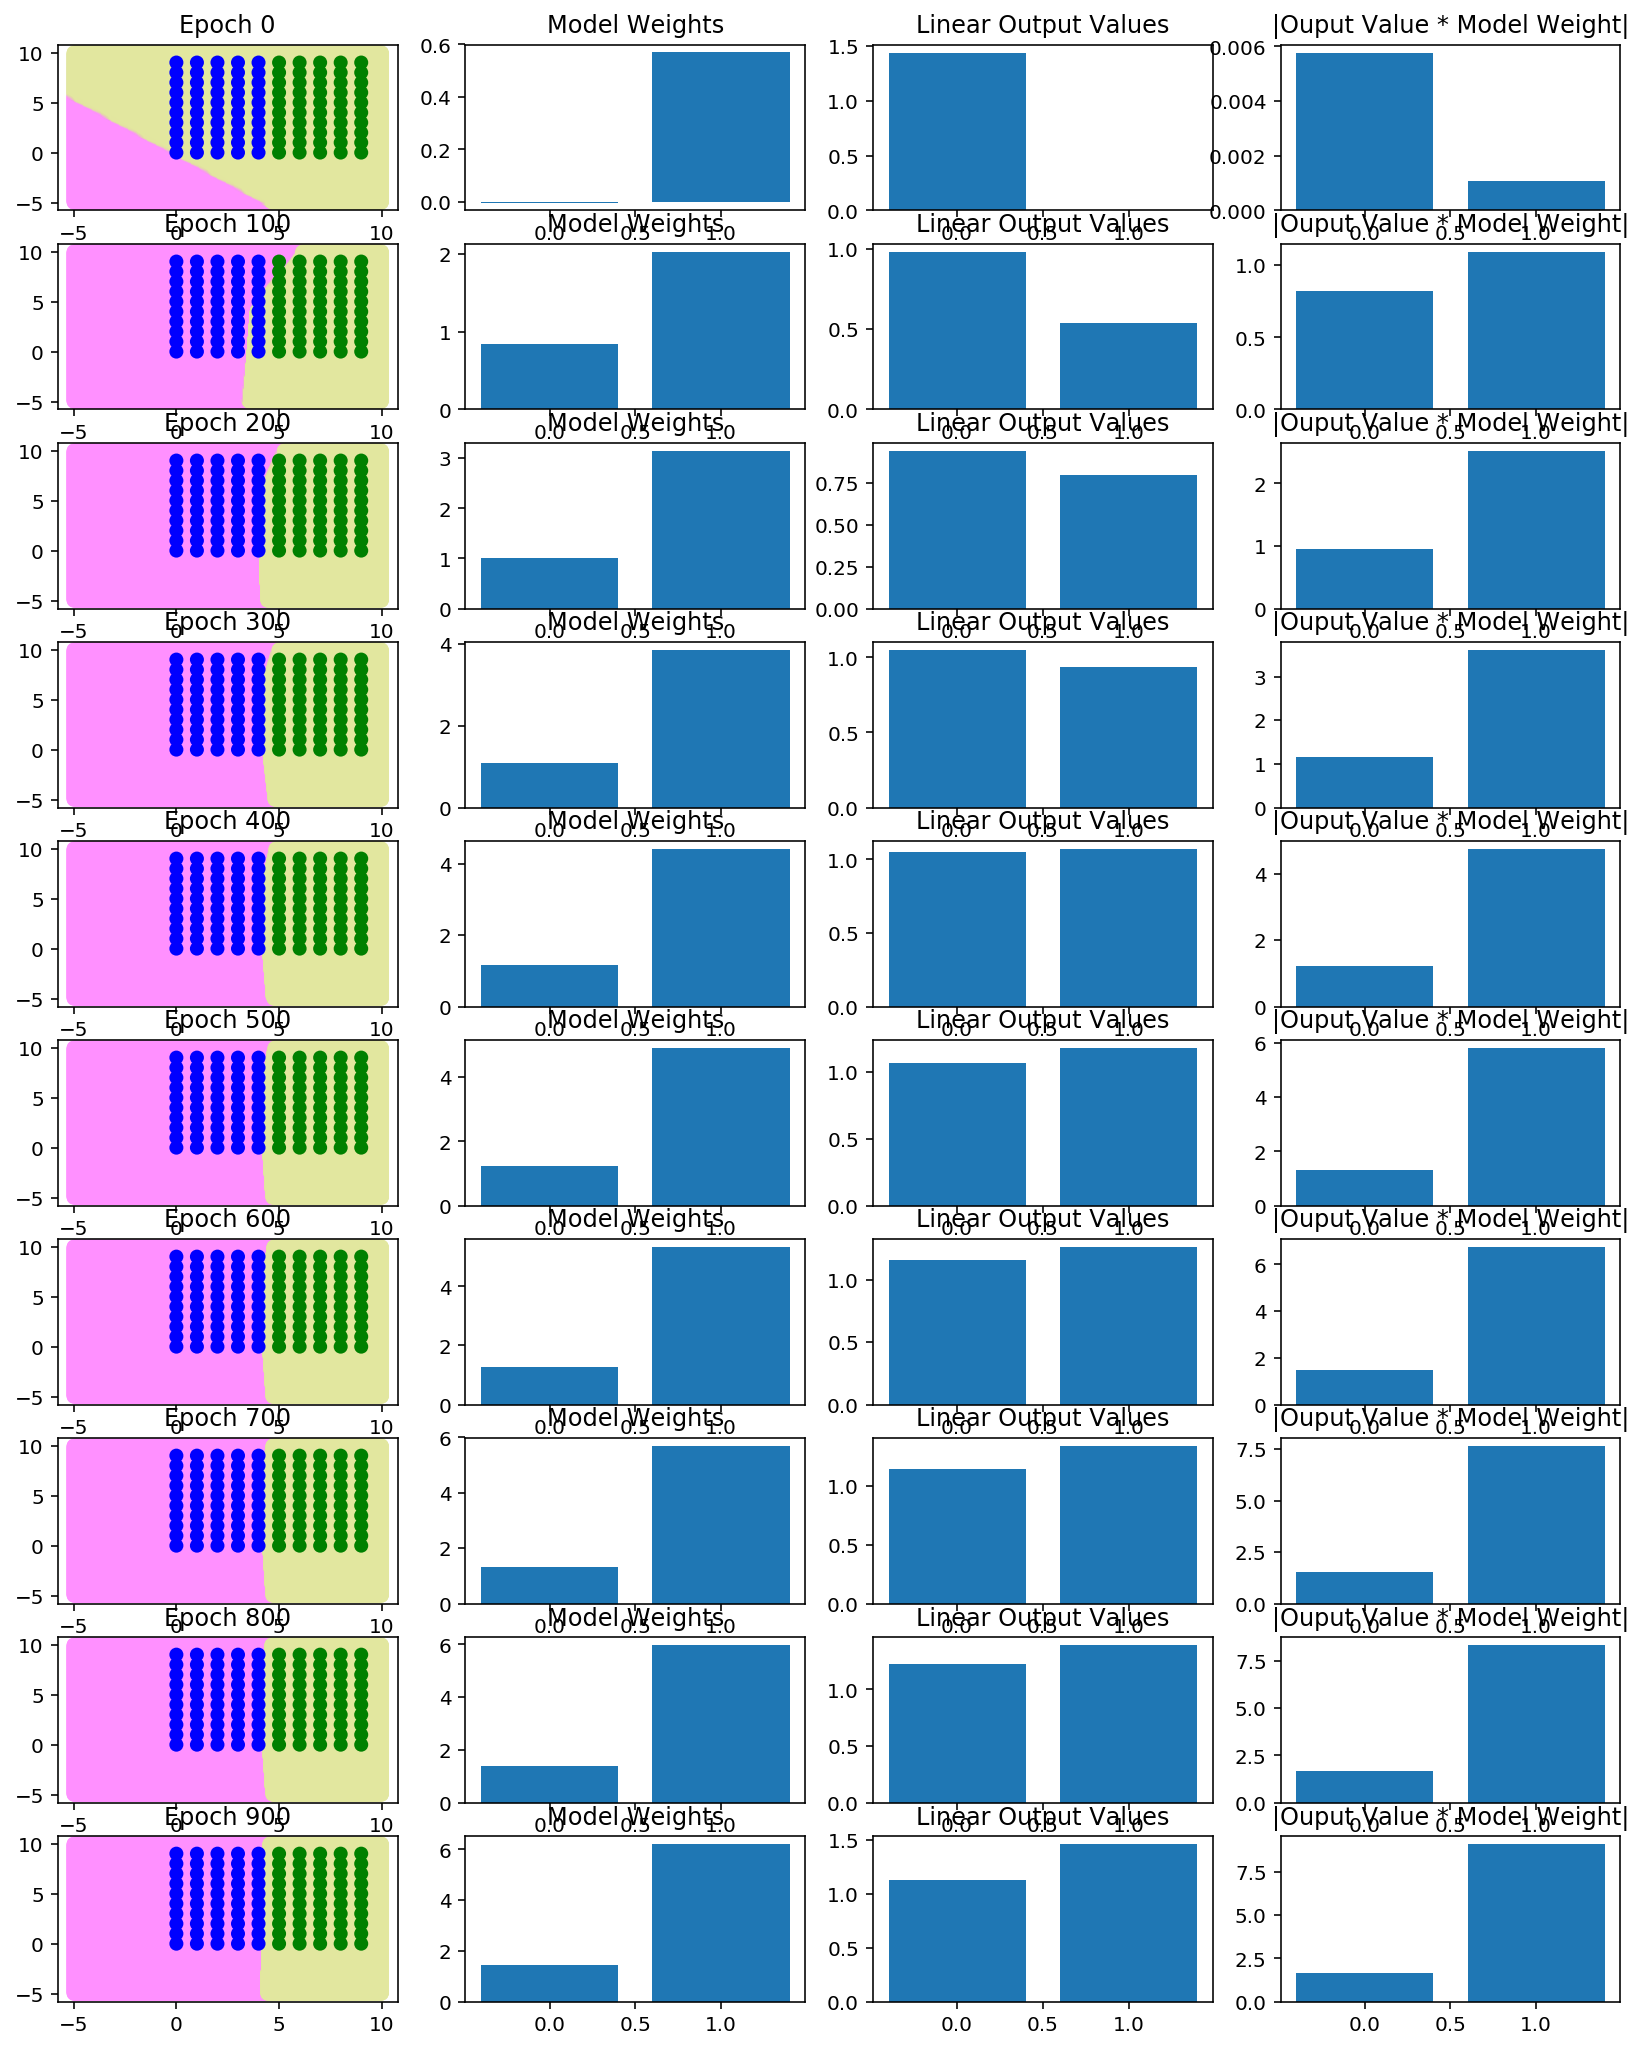

The loss is 0.009006140753626823
Final charts on test data


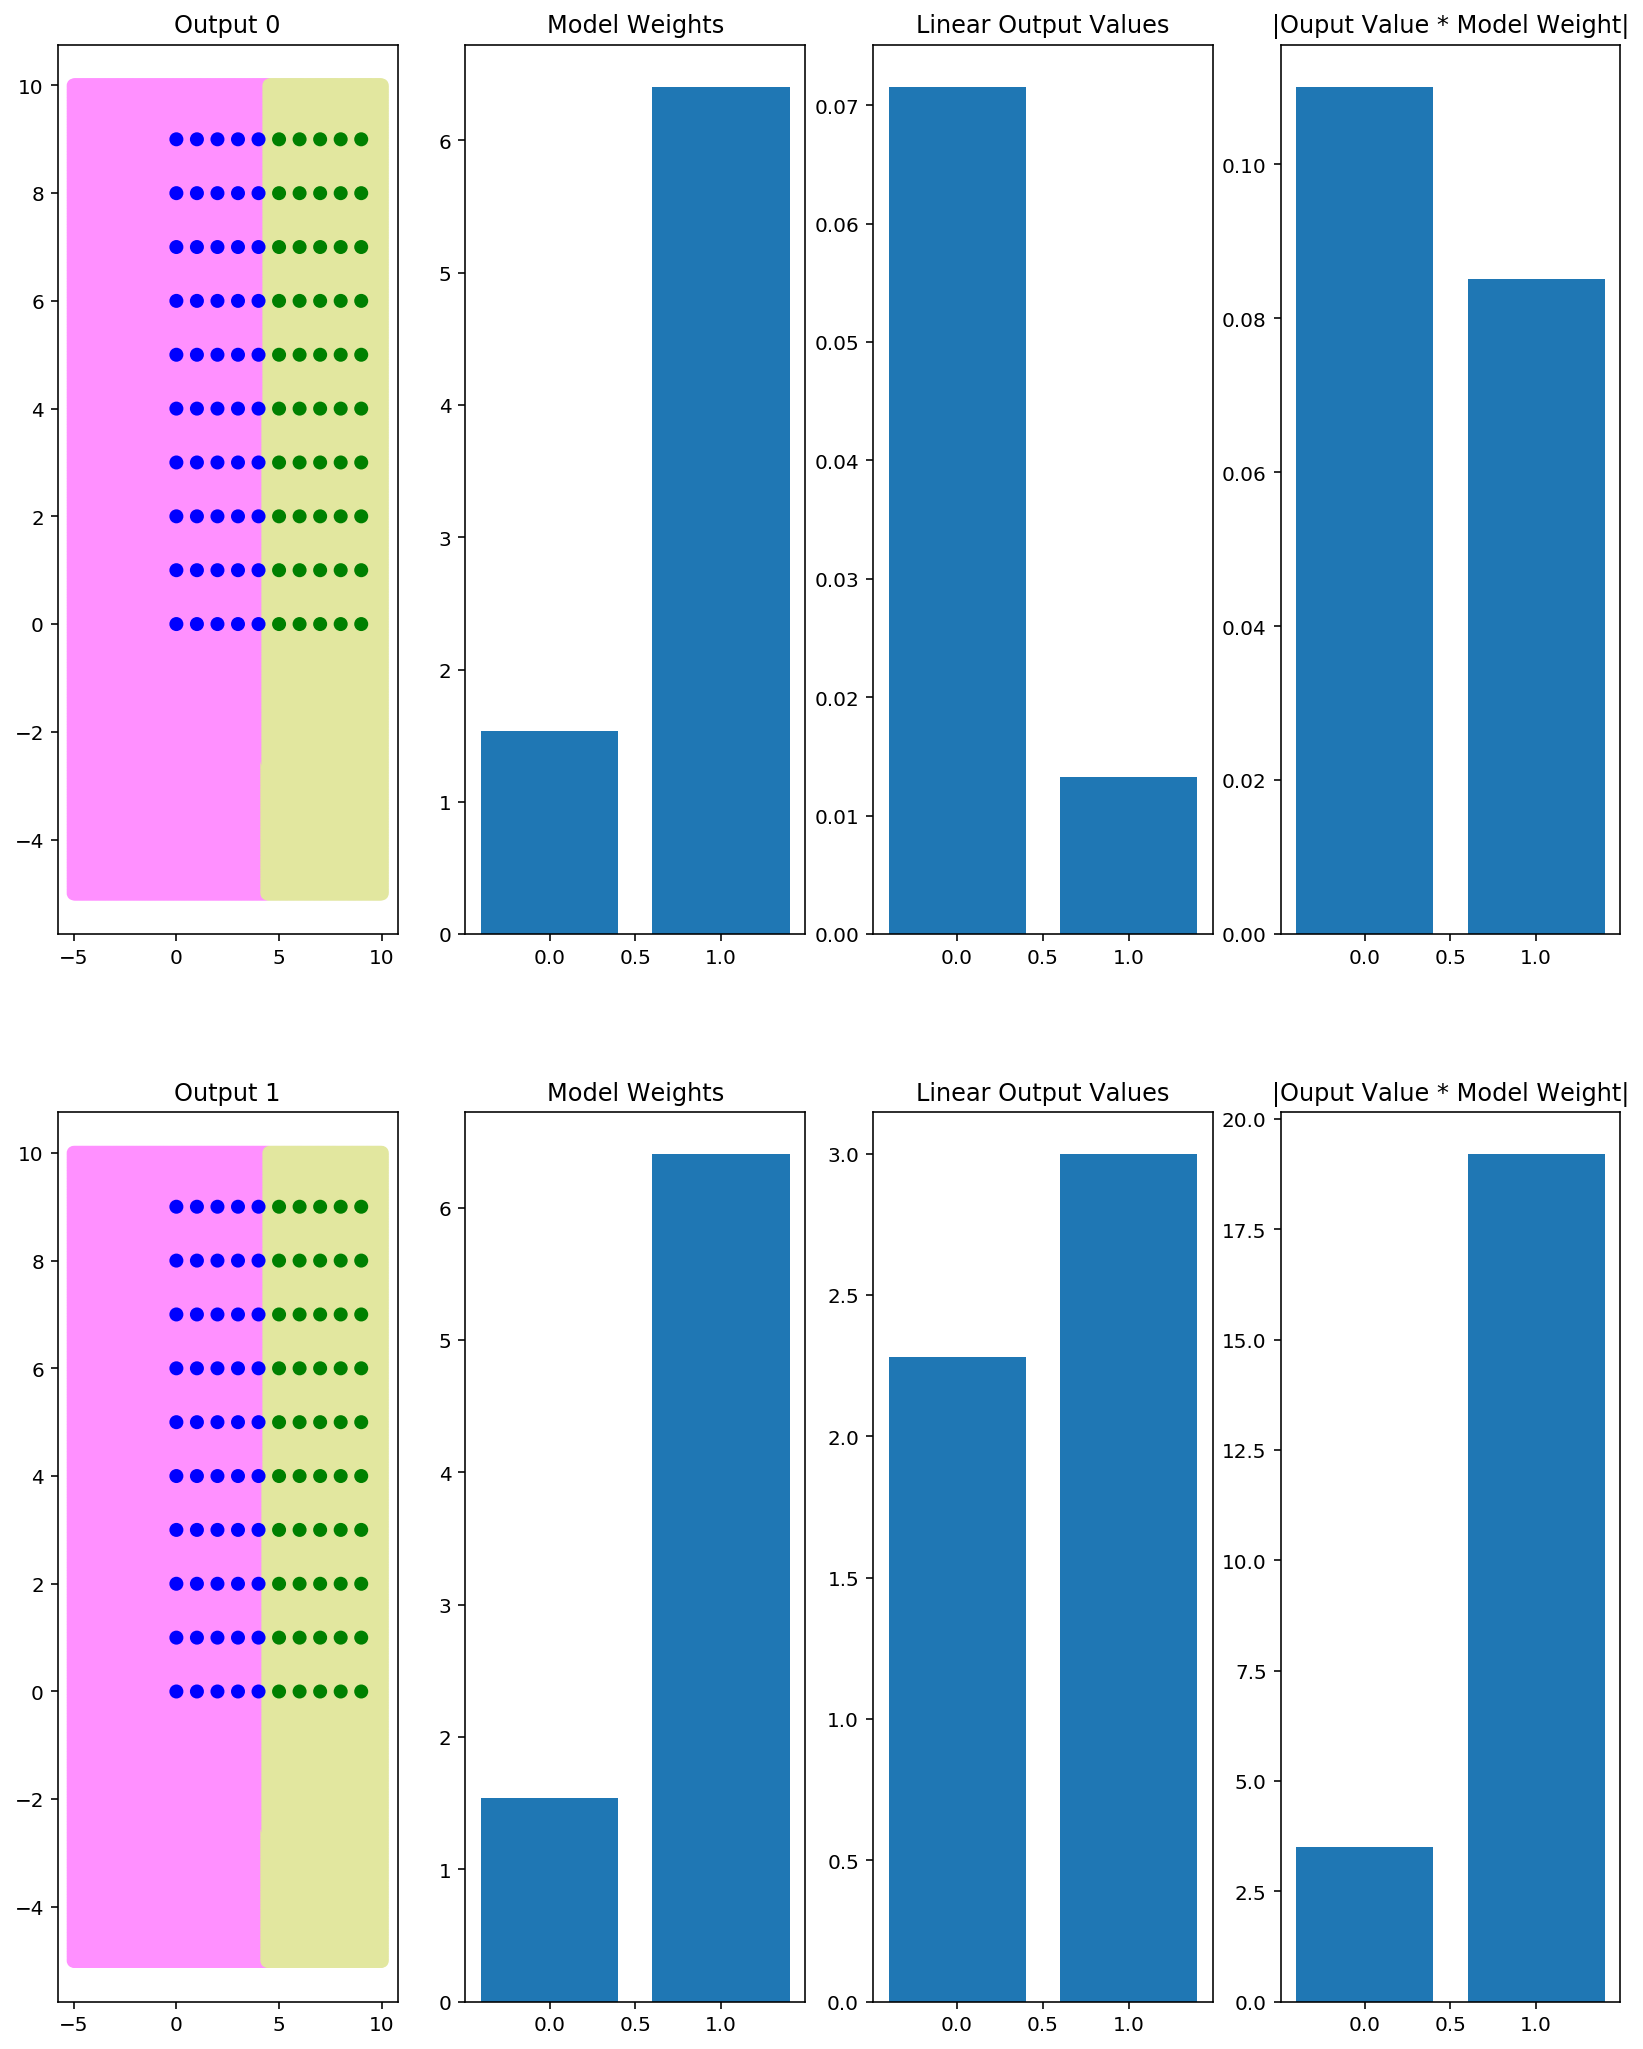

In [16]:
torch.manual_seed(0)

d = 2
#get data for new model
x1 = []
y1 = []
for z in range(0,5):
    for z1 in range(10):
        x1.append([z,z1])
        y1.append([1])

x2 = []
y2 = []
for z in range(5,10):
    for z1 in range(10):
        x1.append([z,z1])
        y2.append([0])

x = x1 + x2
y = y1 + y2

x = torch.FloatTensor(x)
y = torch.FloatTensor(y)



H = 2
model = nn.Sequential(nn.Linear(d,H), # Shape: [2, 20]
                     nn.ReLU(),       # Shape: [20, 20]
                     nn.Linear(H,1),  # Shape: [20, 1]
                      nn.Sigmoid())   # Shape: [1, 1]

crit = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
loss = train(x,y,model,crit)
print("The loss is " + str(loss.tolist()))

print("Final charts on test data")
plot_fin_model(model,x,y)

## Data set 1

<Figure size 720x720 with 0 Axes>

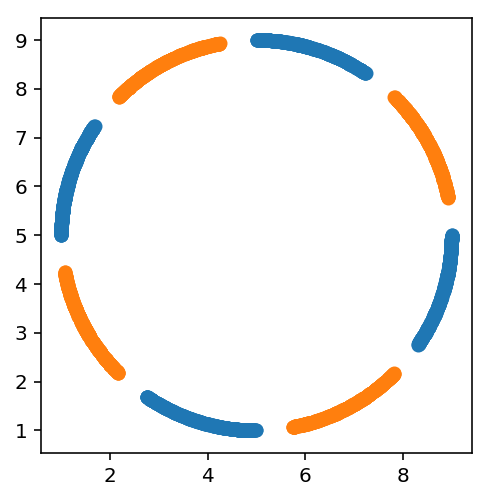

2800
2800


In [11]:
seq = np.linspace(0,1,9)
pairs = [(seq[i] + .03, seq[i+1]) for i in range(len(seq[:-1]))]

n = 250
r = 4
x = 5
y = 5

data = []
d1 = []
d2 = []
l1 = []
l2 = []

labels = []
for i, pair in enumerate(pairs):
    datum = gen_circle(350, x, y, r, disk_start = 1, circ_start = pair[0], circ_end = pair[1])
    if (i % 2):
        d1 += datum
    else:
        d2 += datum

l1 = [[1]]*len(d1)
l2 = [[0]]*len(d2)


x = torch.FloatTensor(d1 + d2)
y = l1 + l2
y = torch.FloatTensor(y)
plot(d1, d2)
print(len(x))
print(len(y))

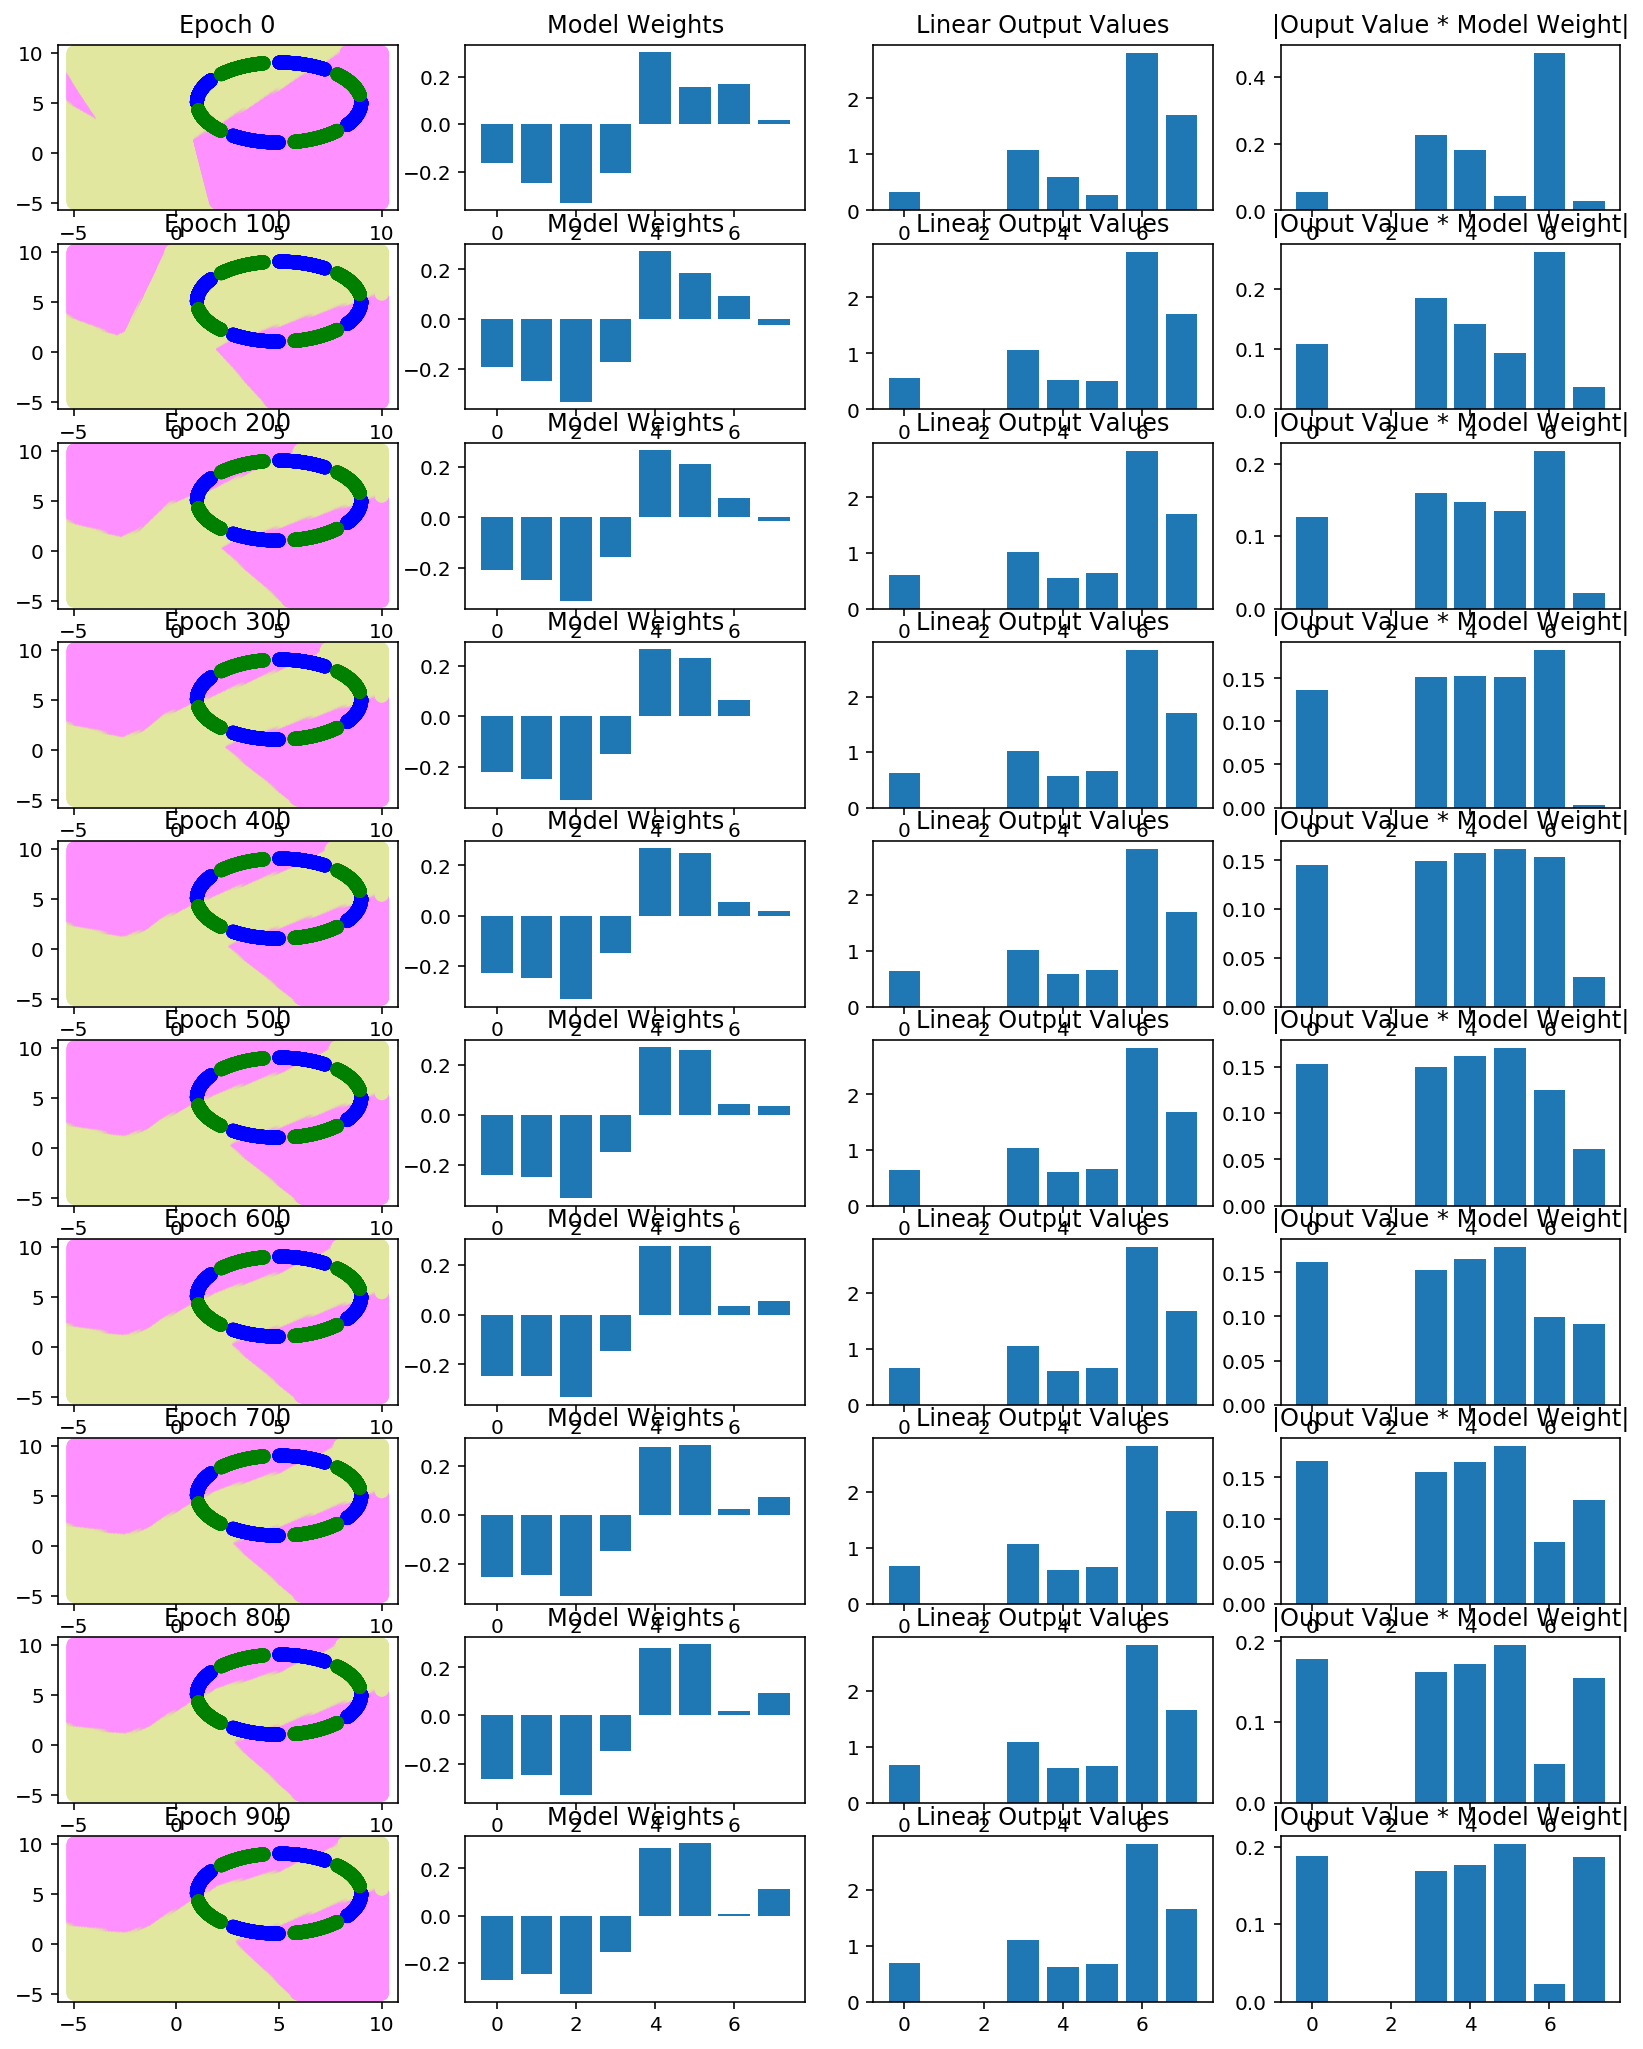

The loss is 0.678648829460144


In [12]:
#for ind in range(3):

H = 8
model = nn.Sequential(nn.Linear(d,H),
                     nn.ReLU(),
                     nn.Linear(H,1),
                      nn.Sigmoid())

crit = torch.nn.BCELoss()
#optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
loss = train(x,y,model,crit)
print("The loss is " + str(loss.tolist()))

#### Final model params output

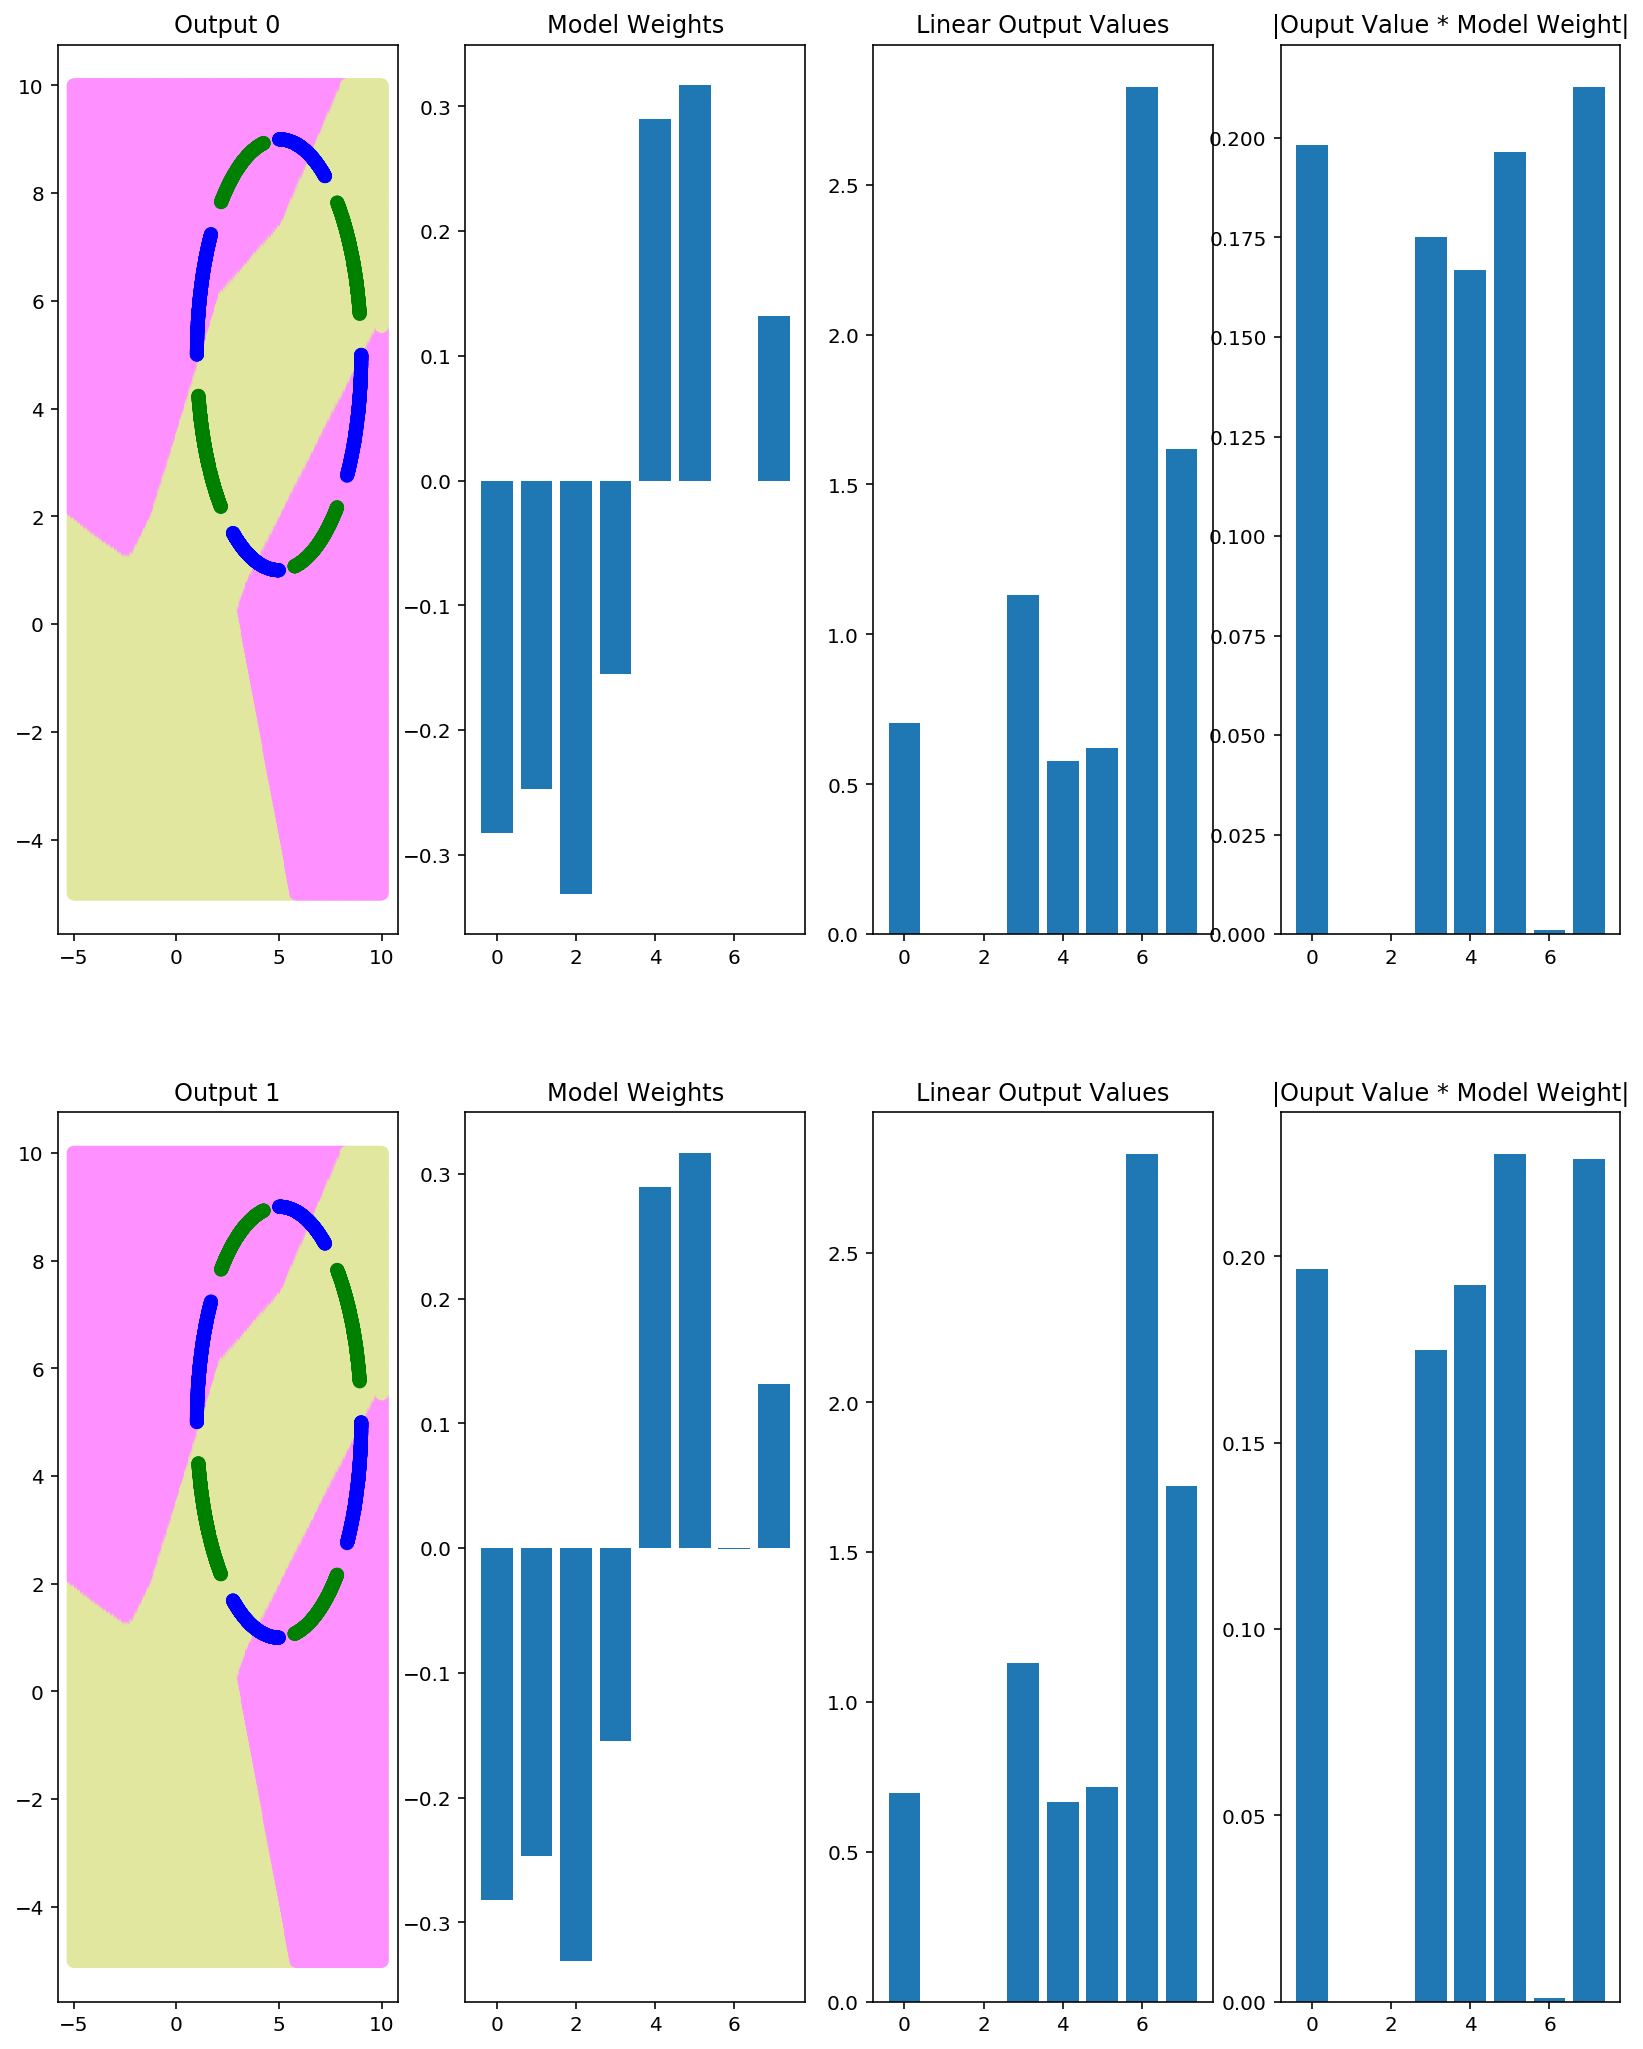

torch.Size([2800, 2])
torch.Size([2800, 1])


NameError: name 'output' is not defined

## Data set 2

In [ ]:
n = 250
r = 3
x = 5
y = 5

data1 = gen_circle(350, x, y, r, disk_start = .6, circ_start = 0 , circ_end = 1)
data2 = gen_circle(350, x, y, 1.5, disk_start = .4, circ_start = 0 , circ_end = 1)

plot(data1, data2)

x = torch.FloatTensor(data1 + data2)
y = ([[0]] * len(data1)) + ([[1]] * len(data2))
y = torch.FloatTensor(y)
print(len(x))
print(len(y))

In [ ]:
output1.shape

In [ ]:
#for ind in range(3):

H = 5
model = nn.Sequential(nn.Linear(d,H),
                     nn.ReLU(),
                     nn.Linear(H,1),
                      nn.Sigmoid())

crit = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
loss = train(x,y,model,crit)
print("The loss is " + str(loss.tolist()))

## Data set 2

In [ ]:
n = 250
r = 3
x = 5
y = 5

data5 = gen_circle(400, x - 1, y, r, disk_start = .6, circ_start = -.02 , circ_end = .55)
data6 = gen_circle(400, x + 1.5, y + 1.5, r, disk_start = .6, circ_start = .48 , circ_end = 1.02)

plot(data5, data6)

x = torch.FloatTensor(data5 + data6)
y = ([[0]] * len(data5)) + ([[1]] * len(data6))
y = torch.FloatTensor(y)


In [ ]:
#for ind in range(3):

H = 25
model = nn.Sequential(nn.Linear(d,H),
                     nn.ReLU(),
                     nn.Linear(H,1),
                      nn.Sigmoid())

o = []

def hook(module, input, output):
    o.append(output)

model[1].register_forward_hook(hook)

crit = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
loss = train(x,y,model,crit)

## Data Set 3

## Data Set 4

In [ ]:
#get data for new model
x1 = []
for z in range(1,11):
    x1.append([z,1])
    x1.append((1,z))
    x1.append((10,z))
    x1.append((z,10))
y1 = [[0] for x in range(len(x1))]
x2 = []
y2 = []
for z in range(200):
    r = 4 * (random.random() ** 0.5)
    theta = random.random() * 2 * 3.14159
    x = 5 + r * cos(theta)
    y = 5 + r * sin(theta)
    x2.append([x,y])
    y2.append([1])

x = x1 + x2
y = y1 + y2



x = torch.FloatTensor(x)
y = torch.FloatTensor(y)
print(np.shape(x))
print(np.shape(y))
#for ind in range(3):

H = 5
model = nn.Sequential(nn.Linear(d,H),
                     nn.ReLU(),
                     nn.Linear(H,1),
                      nn.Sigmoid())

crit = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
loss = train(x,y,model,crit)
print("The loss is " + str(loss.tolist()))

In [ ]:
#another 3 data sets
#write update rules for gradient descent
#generate outputVal * modelWeight graphs during training to see how they change
#when do the neural networks actually decide weights?
#use SGD when doing update rules
#write findings about initialization and patterns in training

#data sets: binary data sets with lots of clusters(a bunch of clusters on the edge of a circle, should need K boundries)
#number of clusters is variable(how many hidden units needed for k clusters?)
#how do hidden units scale with number of clusters

## Data set 5

In [ ]:

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500

noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.8, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)



datasets = [
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {})]


data = []
for i_dataset, (dataset, algo_params) in enumerate(datasets[len(datasets) - 2:]):
#     update parameters with dataset-specific values

    X, y = dataset
    data.append((X,y))

print(data[0])
print(len(data))

In [ ]:
d=2
new_y = np.array([0 if x < 2 else 1 for x in data[0][1]])
x = torch.FloatTensor(data[0][0])
y = torch.FloatTensor(new_y.reshape(1500,1))
print(x.shape)
print(y.shape)
#for ind in range(3):

H = 5
model = nn.Sequential(nn.Linear(d,H),
                     nn.ReLU(),
                     nn.Linear(H,1),
                      nn.Sigmoid())

crit = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
loss = train(x,y,model,crit)
print("The loss is " + str(loss.tolist()))

In [ ]:
d=2
new_y = np.array([0 if x == 0 or x == 2 else 1 for x in data[1][1]])
x = torch.FloatTensor(data[1][0])
y = torch.FloatTensor(new_y.reshape(1500,1))
print(x.shape)
print(y.shape)
#for ind in range(3):

H = 5
model = nn.Sequential(nn.Linear(d,H),
                     nn.ReLU(),
                     nn.Linear(H,1),
                      nn.Sigmoid())

crit = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
loss = train(x,y,model,crit)
print("The loss is " + str(loss.tolist()))